<a href="https://colab.research.google.com/github/KajalMishra-29/ML-LungCancerClassifier/blob/main/resnet_lung_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
import os
import cv2
import numpy as np
import random
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

Image Preprocessing

In [3]:
directory = '/content/MyDrive/MyDrive/IQ-OTHNCCD_lung_cancer_dataset'
categories = ['Benign_cases', 'Malignant_cases', 'Normal_cases']

data = []
for i in categories:
  path = os.path.join(directory, i)
  class_num = categories.index(i)

  for file in os.listdir(path):
    file_path = os.path.join(path, file)
    img = cv2.imread(file_path)
    # preprocess steps
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    data.append([img, class_num]);

random.shuffle(data)

X, y = [], []
for feature, label in data:
  X.append(feature)
  y.append(label)

print('X length : ', len(X));
print('y counts : ', Counter(y))

X = np.array(X)
y = np.array(y)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=10, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10, stratify=y_temp)

early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

X length :  1097
y counts :  Counter({1: 561, 2: 416, 0: 120})


Model with Transfer learning

In [17]:
# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Custom fully connected layer
x = Dropout(0.5)(x) # Dropout to Avoid Overfitting:
output = Dense(3, activation='softmax')(x)  # Output layer for 3 classes

resnet_model = Model(inputs=base_model.input, outputs=output)

# Freeze the base model layers initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history = resnet_model.fit(X_train, y_train,batch_size=32,
                           validation_data=(X_valid, y_valid),
                           epochs=30,
                           shuffle = True,
                           )

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3314 - loss: 1.9178 - val_accuracy: 0.5104 - val_loss: 1.0769
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 224ms/step - accuracy: 0.4202 - loss: 1.3521 - val_accuracy: 0.5703 - val_loss: 0.9102
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.4611 - loss: 1.1557 - val_accuracy: 0.5286 - val_loss: 0.9088
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - accuracy: 0.5045 - loss: 1.0589 - val_accuracy: 0.5156 - val_loss: 0.8899
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.5193 - loss: 1.0154 - val_accuracy: 0.5260 - val_loss: 0.8709
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.5165 - loss: 0.9869 - val_accuracy: 0.6484 - val_loss: 0.8519
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.5477 - loss: 1.0154 - val_accuracy: 0.6406 - val_loss: 0.8371
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 227ms/step - accuracy: 0.5765 - loss: 0.9684 - val_accuracy: 0.64

Unfreeze Some Layers for Fine-Tuning:

After the initial training, unfreeze some of the top layers in the base model to fine-tune them on your dataset. Lower the learning rate to avoid large updates that could erase pre-trained weights

In [11]:
# Unfreeze top layers of the base model
for layer in resnet_model.layers[-30:]:  # Adjust number of layers as needed
    layer.trainable = True

# Recompile the model with a lower learning rate
resnet_model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Fine-tune the model
history_fine = resnet_model.fit(X_train ,y_train,
                                validation_data=(X_valid ,y_valid),
                                epochs=40,
                                batch_size=32,
                                shuffle = True,
                                )

Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.5750 - loss: 0.9510 - val_accuracy: 0.6719 - val_loss: 0.8307
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 259ms/step - accuracy: 0.7541 - loss: 0.6870 - val_accuracy: 0.7057 - val_loss: 0.8260
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.7882 - loss: 0.5758 - val_accuracy: 0.7109 - val_loss: 0.8251
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - accuracy: 0.8930 - loss: 0.4088 - val_accuracy: 0.7109 - val_loss: 0.8261
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step - accuracy: 0.8563 - loss: 0.4030 - val_accuracy: 0.7109 - val_loss: 0.8298
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.9153 - loss: 0.2973 - val_accuracy: 0.6953 - val_loss: 0.8316
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.9313 - loss: 0.2915 - val_accuracy: 0.6641 - val_loss: 0.8304
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 262ms/step - accuracy: 0.9561 - loss: 0.2440 - val_accuracy: 0.6

# REPORT

In [12]:
y_pred = resnet_model.predict(X_test, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_bool)
print(f"Accuracy: {accuracy:.4f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 659ms/step
Accuracy: 0.9576


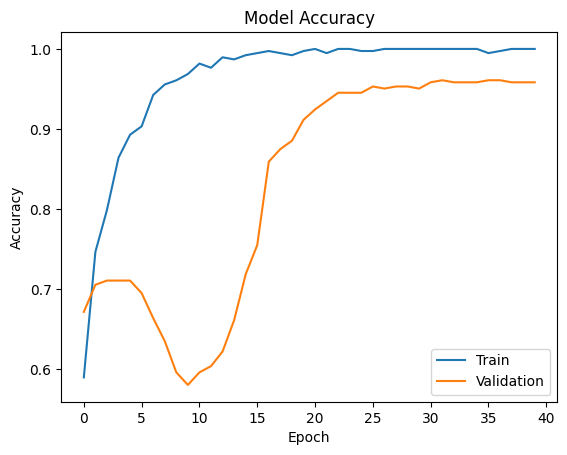

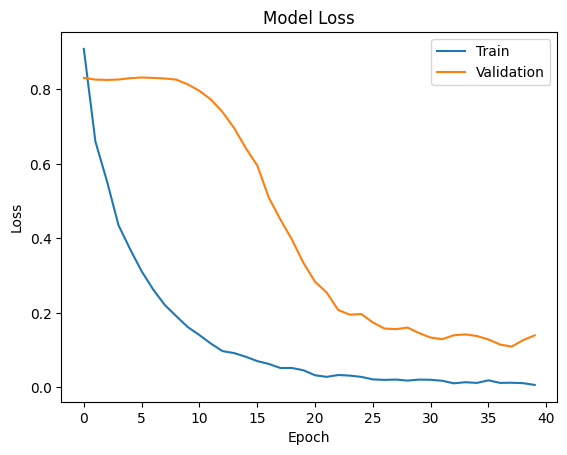

In [13]:
# Plot model accuracy
import matplotlib.pyplot as plt
plt.plot(history_fine.history['accuracy'], label='Train')
plt.plot(history_fine.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot model loss
plt.plot(history_fine.history['loss'], label='Train')
plt.plot(history_fine.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

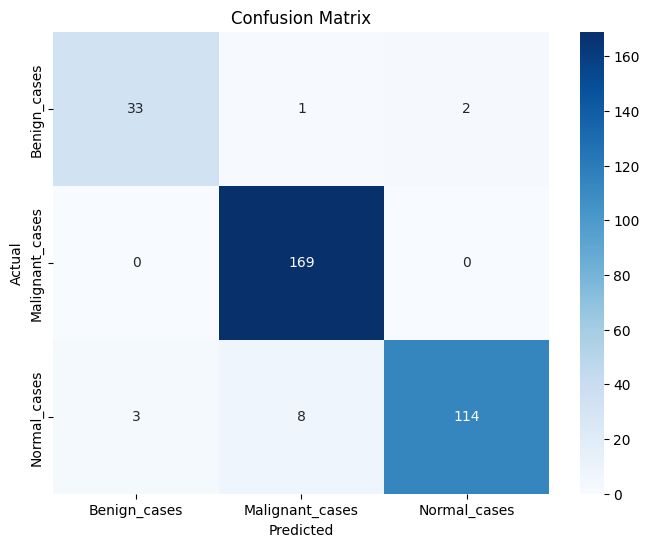

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred_bool)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step 


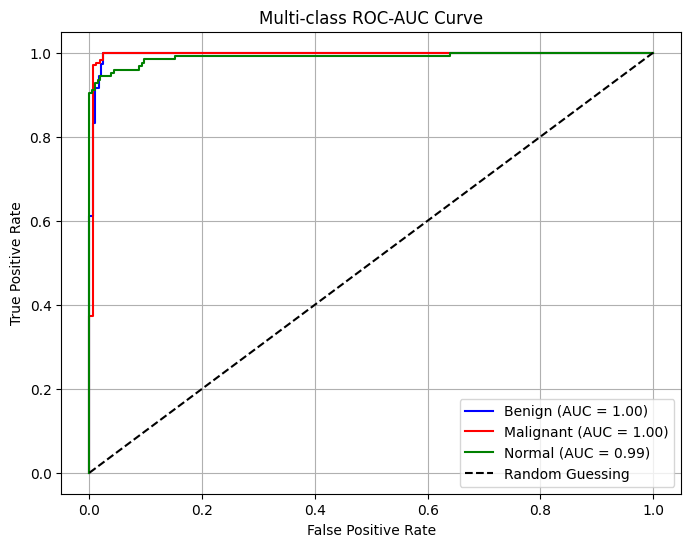

In [15]:
# Binarize the labels for ROC-AUC (one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_prob = resnet_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
labels = ['Benign', 'Malignant', 'Normal']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"{labels[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC-AUC Curve')
plt.legend()
plt.grid()
plt.show()